In [322]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.linear_model import LinearRegression

from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error

from math import sin, cos, atan2, sqrt, pi
from eda_helpers import normality_check, count_outliers

**1. Start from the Summary coming from the Exploratory Data Analysis (EDA)**

**Summary:**
 - Target: `Price` numerical continuous variable;
 - There are 6 features: 4 continuous, 2 text;
 - There are 3 missing values in target variable;
 - There are no missing values in features;
 - `Price`, `Area` and `Room` have right-skewed distribution and 56, 33, 62 outliers respectively. However if we look closer to these outliers, we'll see that all of them are just big (and thus expencive) houses. These values will not be considered as outliers;
 - There are 2 outiers in `Longitude`, that are much lower than the mean;
 - Outliers of `Latitude` create a cluster togeter with other points and will not be considered as outliers.
 - There is one point, which is an outlier niether for longitude, not for latitude, but when plotting coordinates, we see that it is far from the main distribution of points. It will be considered an outlier;
 - Most values of both text features (`Address` and `Zip`) are unique, thus not informative for prediction;
 - When removing letters from `Zip` code, there are 70 unique values, which represent areas of the city. The assumption is they are more generalized, than original format of zip code.
 

**2. Begin to process the dataset accordingly, e.g., by dealing with missing values, feature engineering and transformation;**

In [323]:
data = pd.read_csv("data/data_train.csv")

data_info = pd.read_csv("data/data_info.csv", index_col=0)
print(f'o Shape of train dataset: {data.shape}')
display(data.sample(3))
print('o Data information')
display(data_info.transpose())
print(f'o Number of duplicate rows that will be removed: {data.duplicated().sum()}')
print(f'o Data type in Dataset: {data_info["data_type"].unique()}')
print(f"o Columns: {data_info.index.tolist()}")

o Shape of train dataset: (739, 7)


,Address,Zip,Price,Area,Room,Lon,Lat
639,"Singel 115 B, Amsterdam",1012 VH,1150000.0,162,5,4.890591,52.375342
482,"Koolpalmhof 18, Amsterdam",1104 DH,375000.0,104,3,4.983057,52.318698
31,"Marcantilaan 225, Amsterdam",1051 NB,300000.0,41,2,4.867456,52.375584


o Data information


,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,text,text,continuous,descrete,continuous,continuous
missing values,3,0,0,0,0,0,0
distribution,right_skewed,not applicable,not applicable,right_skewed,right_skewed,normal,heavy_tailed
n outliers,0,0,0,0,0,3,3


o Number of duplicate rows that will be removed: 1
o Data type in Dataset: ['continuous' 'text' 'descrete']
o Columns: ['Price', 'Address', 'Zip', 'Area', 'Room', 'Lon', 'Lat']


In [324]:
#remove duplicates:
data = data.drop_duplicates()

# remove Longitude outliers (Lon < 4.7)
data.drop(data[data['Lon']< 4.7].index, inplace=True)

# reset indexes after removing rows
data = data.reset_index()
data = data.drop(columns=['index'])
data.tail()


,Address,Zip,Price,Area,Room,Lon,Lat
731,"Joop Gerritzestraat 14, Amsterdam",1063 EK,500000.0,113,6,4.830151,52.383526
732,"Laan van Vlaanderen 141 A2*, Amsterdam",1066 MP,285000.0,37,2,4.807805,52.344914
733,"Henri Zagwijnstraat 14 3, Amsterdam",1077 XR,685000.0,107,4,4.868754,52.341846
734,"Marnixstraat 237 E, Amsterdam",1015 WE,275000.0,23,1,4.877725,52.376041
735,"Zandstraat 5 hs, Amsterdam",1011 HJ,560000.0,80,2,4.898846,52.370303


**3. For supervised learning, study the relationship between features, a.k.a. independent variables (IV), with the target, a.k.a. the dependent variable (DV).**


- **a.** Study the [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) for both **Discrete** and **Numerical** features.
- **b.** Apply $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) between two **Nominal** variables;
- **c.** If necessary, transform or construct new features and re-apply the same statistical test;

**!!!** whenever possible, plot the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced facets;

* Before applying tests it makes sence to fill the missing values:

In [325]:
missing_data = data[data.isna().any(axis=1)]
missing_data

,Address,Zip,Price,Area,Room,Lon,Lat
84,"Suikerplein 16, Amsterdam",1013 CK,NaN,81,3,4.880976,52.389623
173,"Falckstraat 47 A, Amsterdam",1017 VV,NaN,147,3,4.897454,52.360707
180,"Haarlemmerweg 705, Amsterdam",1067 HP,NaN,366,12,4.787874,52.383877


To determine missing prices it is possible to count average price per square meter (sqm) in the neighbourhood and then multiply it by the house's area:

In [326]:
zips = []

for i in range(missing_data.shape[0]):
    zips.append(list(missing_data['Zip'])[i][:4])

data['Price per sqm'] = data['Price'] / data['Area']

for i in zips:

    #create dataframe with all houses in the neighbourhood
    data_copy = data.loc[data['Zip'].str.contains(i)]
    display(data_copy)

    # get avg price per sqm in the neighbourhood
    mean = data_copy.loc[(data_copy['Zip'].str.contains(i)), 'Price per sqm'].mean()

    #set this value to the row with missing price
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price per sqm'] = mean
    print(f'o Avg Price per sqm in the neighbourhood: {mean}')

    # get area value of the row with missing price
    area = data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Area']

    # set missing price by multiplying average price by size of the house in sqm
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price'] = mean * area
    # display(data.loc[data['Zip'].str.contains(i)])


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
42,"Spaarndammerplantsoen 20, Amsterdam",1013 XT,425000.0,52,2,4.876149,52.390376,8173.076923
84,"Suikerplein 16, Amsterdam",1013 CK,NaN,81,3,4.880976,52.389623,NaN
85,"Martin Vlaarkade 97, Amsterdam",1013 CS,425000.0,75,3,4.881400,52.388529,5666.666667
109,"Haparandaweg 932 A, Amsterdam",1013 BD,500000.0,76,3,4.878134,52.395229,6578.947368
147,"Winthontstraat 28, Amsterdam",1013 BR,525000.0,69,3,4.892282,52.384356,7608.695652
184,"Haarlemmerstraat 98 B, Amsterdam",1013 EW,750000.0,119,6,4.890977,52.380642,6302.521008
247,"Van Noordtkade 140, Amsterdam",1013 CA,335000.0,61,2,4.881952,52.389025,5491.803279
253,"Oostzaanstraat 271, Amsterdam",1013 WJ,375000.0,52,3,4.872555,52.392426,7211.538462
270,"Westerdok 452, Amsterdam",1013 BH,1250000.0,147,4,4.891955,52.385140,8503.401361
372,"Brouwersgracht 182 I, Amsterdam",1013 HC,500000.0,72,2,4.887619,52.381092,6944.444444


o Avg Price per sqm in the neighbourhood: 7194.066645286559


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
2,"Prinsengracht 1035 D, Amsterdam",1017 KP,825000.0,148,3,4.895224,52.361929,5574.324324
67,"Lange Leidsedwarsstraat 103 1 A, Amsterdam",1017 NJ,375000.0,38,1,4.886109,52.363042,9868.421053
72,"Amstel 124 B, Amsterdam",1017 AD,575000.0,70,2,4.897782,52.366928,8214.285714
165,"Bakkersstraat 11, Amsterdam",1017 CW,650000.0,81,3,4.897432,52.366729,8024.691358
173,"Falckstraat 47 A, Amsterdam",1017 VV,NaN,147,3,4.897454,52.360707,NaN
181,"Amstel 102, Amsterdam",1017 AD,2325000.0,150,6,4.896842,52.366965,15500.000000
217,"Maarten Jansz. Kosterstraat 10, Amsterdam",1017 VX,650000.0,67,4,4.901713,52.360545,9701.492537
243,"Lange Leidsedwarsstraat 103 1 B, Amsterdam",1017 NJ,399000.0,40,2,4.886109,52.363042,9975.000000
250,"Utrechtsedwarsstraat 4, Amsterdam",1017 WG,1700000.0,194,6,4.896542,52.360937,8762.886598
252,"Lange Leidsedwarsstraat 95 C, Amsterdam",1017 NH,475000.0,58,3,4.885902,52.363158,8189.655172


o Avg Price per sqm in the neighbourhood: 9698.018857575895


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
52,"Gerda Brautigamstraat 37, Amsterdam",1067 VM,545000.0,110,4,4.789083,52.379219,4954.545455
133,"Hendrik Bulthuisstraat 8, Amsterdam",1067 SC,345000.0,69,4,4.795948,52.374337,5000.000000
154,"Sam van Houtenstraat 191 C, Amsterdam",1067 JG,375000.0,94,4,4.800745,52.379133,3989.361702
180,"Haarlemmerweg 705, Amsterdam",1067 HP,NaN,366,12,4.787874,52.383877,NaN
223,"Willem Kromhoutstraat 17, Amsterdam",1067 RC,380000.0,77,4,4.795007,52.375474,4935.064935
231,"J.G. Suurhoffstraat 123, Amsterdam",1067 VR,425000.0,102,4,4.789341,52.380775,4166.666667
339,"Van Karnebeekstraat 7, Amsterdam",1067 RG,375000.0,69,4,4.799561,52.374310,5434.782609
401,"Pieter van der Werfstraat 44, Amsterdam",1067 EP,380000.0,100,4,4.802560,52.380679,3800.000000
402,"Philip Vingboonsstraat 19, Amsterdam",1067 BG,375000.0,84,4,4.795800,52.383180,4464.285714
479,"Teldershof 57, Amsterdam",1067 ML,350000.0,88,3,4.800286,52.380052,3977.272727


o Avg Price per sqm in the neighbourhood: 4393.697769166612


Add info about 'Price per sqm'

In [327]:
data_info.loc['Price per sqm', 'data_type'] = 'continuous'
data_info.loc['Price per sqm', 'missing values'] = 0
normality_check(data, data_info, ['Price per sqm'])
data_info

,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,not normal,NaN


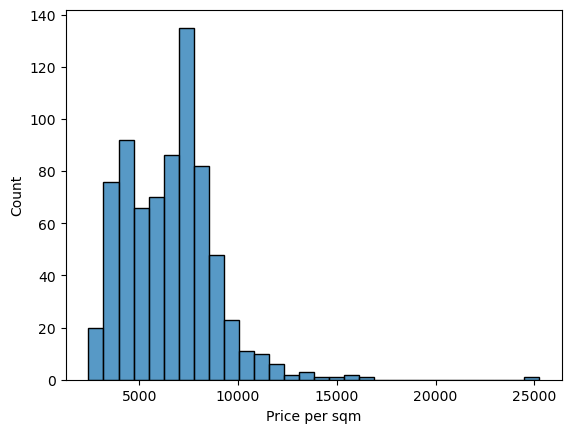

In [328]:
# plot 'Price per sqm' distribution as a histplot
plot = sns.histplot(x = data['Price per sqm'], bins = 30)

**Distribution is right-skewed**

In [329]:
data_info.loc['Price per sqm', 'distribution'] = 'right_skewed'
data_info

,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,NaN


Check outliers of Price per sqm

In [330]:
count_outliers(data = data, data_info = data_info, features = ['Price per sqm'])

o 10 datapoints with Price per sqm > 12484.237438861717


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
14,"Nieuwe Keizersgracht 570 L, Amsterdam",1018 VG,1050000.0,63,3,4.908850,52.365524,16666.666667
100,"Pieter Cornelisz. Hooftstraat 169 B, Amsterdam",1071 BW,1695000.0,117,3,4.876144,52.358928,14487.179487
137,"Prins Hendrikkade 512, Amsterdam",1011 TE,389000.0,30,2,4.906059,52.374085,12966.666667
181,"Amstel 102, Amsterdam",1017 AD,2325000.0,150,6,4.896842,52.366965,15500.000000
196,"Dam 5 V, Amsterdam",1012 JS,4495000.0,178,5,4.894290,52.373106,25252.808989
323,"Huidekoperstraat 24 F, Amsterdam",1017 ZM,2475000.0,183,3,4.897473,52.358943,13524.590164
383,"Leonard Bernsteinstraat 96 A, Amsterdam",1082 MR,1750000.0,130,3,4.872151,52.336348,13461.538462
468,"Keizersgracht 544, Amsterdam",1017 EL,5950000.0,394,10,4.887378,52.365078,15101.522843
707,"Diemerzeedijk 76 S, Amsterdam",1087 SM,400000.0,25,2,4.962333,52.362891,16000.000000
710,"Huidekoperstraat 24 F, Amsterdam",1017 ZM,2475000.0,183,4,4.897473,52.358943,13524.590164


The biggest outlier is a house, located on a Dam square, which is the most famous square of Amsterdam, so it is normal, that it is so expencive. Besides that, according to google maps, this house is a new-build or recently renovated. All other houses in outliers list are mostly located in the city center or next to tourist attractions (like row 100 - next to Vondelpark). However row 707 looks weird. That is 25 sqm with 2 rooms and 16k per sqm. According to google maps, that is just a garage for a boat. This datapoint might be a mistake and will be added to list of outliers.

In [331]:
data_info.loc['Price per sqm', 'n outliers'] = 1
data_info

,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,1.0


**a. Study correlations between numerical features:**

As in this dataset most of variables are not distributed normally, we have to create a function, that will dicide if Pearson's or Spearman's correlation test has to be applied:

In [332]:
def custom_corr(data: pd.DataFrame, data_info: pd.DataFrame, features: list = list(data.columns)) -> pd.DataFrame:
    """ Calculate the correlations between all possible pairs of numerical data features depending on their distributions.

    Args:
        data: pd.DataFrame
            dataframe with features
        data_info: pd.DataFrame
            dataframe with information about distribution of data features

    Returns:
        summary: pd.DataFrame: 
            dataframe with the following information about correlations: 
             - method: Pearson or Spearman
             - feature1 and feature2
             - r-value: correlation coefficient
             - p-value: how signifficant is that correlation. 
             - stat-sign: bool. Significance theshold is p-value = 0.05, so 0.04 is significant, 0.06 - not.
             - N: number of observations in each feature.
    """
    summary = pd.DataFrame()
    
    # create lists with normaly / not normaly distributed features
    norm_features = []
    no_norm_features = []
    for i in features:
        if (data_info.loc[i, 'data_type'] == 'continuous') or (data_info.loc[i, 'data_type'] == 'descrete') :
            if data_info.loc[i, 'distribution'] == 'normal':
                norm_features.append(i)
            else:
                no_norm_features.append(i)

    # create list of all possible combinations of features without repeats
    iterator = combinations(norm_features+no_norm_features, 2)

    # get correlations between every pait of features and it's signifficance
    for col1, col2 in iterator:
        if col1 in norm_features and col2 in norm_features:
            r_value, p_value = stats.pearsonr(data.loc[:, col1], data.loc[:, col2])
            method = 'Pearson'
        else: 
            r_value, p_value = stats.spearmanr(data.loc[:, col1], data.loc[:, col2])
            method = 'Spearman'
        n = len(data)

        # Store output in dataframe format
        dict_summary = {
            "method": method,
            "feature1": col1,
            "feature2": col2,
            "r-value": r_value,
            "p-value": p_value,
            "stat-sign": (p_value < 0.05),
            "N": n,
        }
        summary = pd.concat(
            [summary, pd.DataFrame(data=dict_summary, index=[0])],
            axis=0,
            ignore_index=True,
            sort=False,
        )
    return summary


In [333]:
correlations_df = custom_corr(data, data_info)
correlations_df

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,Lon,Price,-0.042635,2.480050e-01,False,736
1,Spearman,Lon,Area,0.052285,1.564759e-01,False,736
2,Spearman,Lon,Room,0.000793,9.828690e-01,False,736
3,Spearman,Lon,Lat,-0.050452,1.715436e-01,False,736
4,Spearman,Lon,Price per sqm,-0.094214,1.054892e-02,True,736
5,Spearman,Price,Area,0.730393,1.208428e-123,True,736
6,Spearman,Price,Room,0.524469,2.998640e-53,True,736
7,Spearman,Price,Lat,0.050838,1.682803e-01,False,736
8,Spearman,Price,Price per sqm,0.456403,3.787774e-39,True,736
9,Spearman,Area,Room,0.761115,3.858506e-140,True,736


As we can see here, most of statistically signifficant correlations are between a feature and a target (in this case there are 2 targets: price and price per sqm). Longitude and Latitude have no impact on price, however both have impact on price per sqm. Also there is positive correlation between Area and Rooms which seems to be fair. This features might be transformed later.

Let's plot Area and Room feature vs. Price to see the character of dependancy:

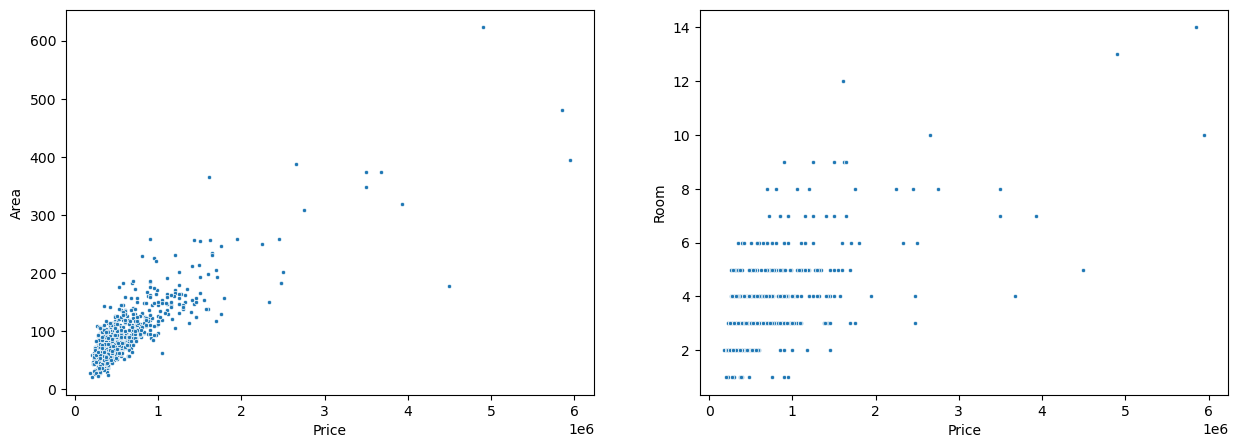

In [334]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for count, feature in enumerate(['Area', 'Room']):
    sns.scatterplot(data = data, x = 'Price', y = feature, marker='.', ax = axes.flatten()[count])

**This 2 feaures don't give us much information: none of them can be described with any known distribution.**

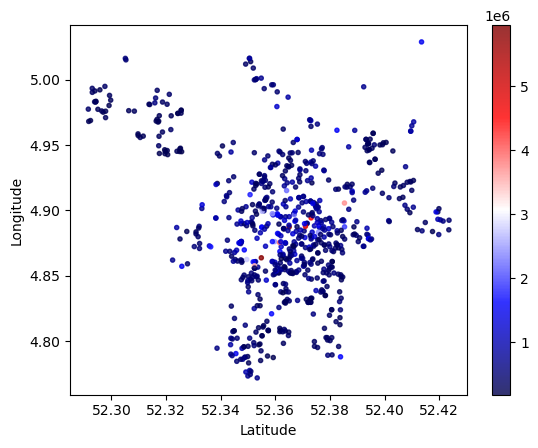

In [335]:
plt.scatter(data['Lat'], data['Lon'], alpha = .8, c = data['Price'], cmap = 'seismic', marker='.')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
cbar = plt.colorbar()

**This plot is more informative: the darkest points are mostly located on the outskirts and central ones are more expencive.**

In [336]:
# show the 5 most central houses

# central = list(data['Distance from center, m'].nsmallest(5))
# data.loc[data['Distance from center, m'].isin(central), :]

In [337]:
# add info about new feature

# data_info.loc['Distance from center, m', 'missing values'] = 0
# data_info.loc['Distance from center, m', 'data_type'] = 'continuous'
# normality_check(data, data_info, ['Distance from center, m'])
# data_info

In [338]:
# plot 'Distance from center' distribution as a histplot

# sns.histplot(data['Distance from center, m'], bins = 20)

In [339]:
# data_info.loc['Distance from center, m', 'distribution'] = 'right_skewed'

In [340]:
# Check if there are any outliers in 'Distance from center, m' 

# count_outliers(data = data, data_info = data_info, features = ['Distance from center, m'], show_details = True)

Point 427 was also considered an outlier during EDA in step of Longitude and Latitude outliers detection. Let's remove it and then **plot Price per sqm vs. Distance from center**

In [341]:
# data.drop(data[data['Lon']==5.029122].index, inplace=True)

# # reset indexes after removing rows
# data = data.reset_index()
# data = data.drop(columns=['index'])

# # just for these plots, in order to see a general picture of prices distribution on the map, let's remove the row with an expreeme 'Price per sqm' value (on Dam square), 
# # because this point is clearly an outlier and will hardly skew the whole distribution

# data1 = data.copy()
# max_price = data1['Price per sqm'].max()
# data1.drop(data1[data1['Price per sqm']==max_price].index, inplace=True)

# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # plot Price per sqm vs. Distance
# sns.scatterplot(data = data1, x = 'Price per sqm', y = 'Distance from center, m', markers='.', ax = axes.flatten()[0])

# # plot map of Latitude and Longitude hued by price per sqm
# plt.scatter(data1['Lat'], data1['Lon'], alpha = .8, c = data1['Price per sqm'], marker = '.', cmap = 'seismic')
# plt.xlabel("Latitude")
# plt.ylabel("Longitude")
# cbar = plt.colorbar()

This distribution looks a little like exponential and can be promising one for the model. Let's run correlation analisys again with a new feature:


In [342]:
# correlations_df = custom_corr(data, data_info)
# correlations_df

As it was expected, there is a **significant negative correlation between Price per sqm and Distance from center**. The impact of Distance on the final house Price is much weaker.

Let's create an initial model and measure the benchmark accuracy. The model will not contain custom features (Price per sqm and Distance from center) and will only require text data transformation and scaling of numerical features:
 1. Address wil be removed as it is unique for every datapoint, so has no predictive power
 2. Zip code will be cut to just numbers and checked if it is correlated with target (every digit in the Zip code has its own meaning, so instead of 1 feature there would be 4)
 3. Price, Area and Room features will be normalized.

In [343]:
# 1. remove extra or unimportant columns
initial_data = data.drop(columns=['Address', 'Price per sqm'])

In [344]:
# 2. transform Zip
initial_data['Zip city'] = np.nan
initial_data['Zip region'] = np.nan
initial_data['Zip location'] = np.nan
initial_data['Zip district'] = np.nan
for row in range(initial_data.shape[0]):
    initial_data.loc[row, 'Zip city'] = int(initial_data.loc[row, 'Zip'][0])
    initial_data.loc[row, 'Zip region'] = int(initial_data.loc[row, 'Zip'][1])
    initial_data.loc[row, 'Zip location'] = int(initial_data.loc[row, 'Zip'][2])
    initial_data.loc[row, 'Zip district'] = int(initial_data.loc[row, 'Zip'][3])
initial_data = initial_data.drop(columns=['Zip'])

display(initial_data['Zip city'].value_counts())
display(initial_data['Zip region'].value_counts())
display(initial_data['Zip location'].value_counts())
display(initial_data['Zip district'].value_counts())

Zip city
1.0    736
Name: count, dtype: int64

Zip region
0.0    674
1.0     62
Name: count, dtype: int64

Zip location
1.0    150
5.0    142
6.0    121
7.0     80
9.0     63
0.0     62
2.0     43
3.0     40
8.0     35
Name: count, dtype: int64

Zip district
7.0    106
4.0     98
5.0     84
3.0     84
2.0     84
1.0     78
8.0     76
6.0     63
9.0     49
0.0     14
Name: count, dtype: int64

In [345]:
# Zip city is always 1, so has no predicrive power
initial_data = initial_data.drop(columns=['Zip city'])

In [346]:
# set data info for the rest of zip features

data_info.loc['Zip region', 'data_type'] = 'descrete'
data_info.loc['Zip location', 'data_type'] = 'descrete'
data_info.loc['Zip district', 'data_type'] = 'descrete'
data_info.loc['Zip region', 'missing values'] = 0
data_info.loc['Zip location', 'missing values'] = 0
data_info.loc['Zip district', 'missing values'] = 0
data_info
normality_check(initial_data, data_info, ['Zip region', 'Zip location', 'Zip district'])

,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,1.0
Zip region,descrete,0.0,not normal,NaN
Zip location,descrete,0.0,not normal,NaN


In [347]:
correlations_df = custom_corr(initial_data, data_info, features=['Price', 'Area', 'Room', 'Lon', 'Lat', 'Zip region', 'Zip location', 'Zip district'])
correlations_df

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,Lon,Price,-0.042635,2.480050e-01,False,736
1,Spearman,Lon,Area,0.052285,1.564759e-01,False,736
2,Spearman,Lon,Room,0.000793,9.828690e-01,False,736
3,Spearman,Lon,Lat,-0.050452,1.715436e-01,False,736
4,Spearman,Lon,Zip region,0.443127,9.491956e-37,True,736
5,Spearman,Lon,Zip location,-0.305502,2.301110e-17,True,736
6,Spearman,Lon,Zip district,-0.047306,1.998722e-01,False,736
7,Spearman,Price,Area,0.730393,1.208428e-123,True,736
8,Spearman,Price,Room,0.524469,2.998640e-53,True,736
9,Spearman,Price,Lat,0.050838,1.682803e-01,False,736


Longitude, Latitude, Zip location and Zip district have no impact on target. Also, Area and room are hightly correlated, so Room will also be removed, because the its impact on target is weaker.

In [348]:
initial_data = initial_data.drop(columns=['Room', 'Lon', 'Lat', 'Zip location', 'Zip district'])
initial_data

,Price,Area,Zip region
0,325000.0,41,0.0
1,2500000.0,202,0.0
2,825000.0,148,0.0
3,699000.0,98,0.0
4,1795000.0,158,0.0
...,...,...,...
731,500000.0,113,0.0
732,285000.0,37,0.0
733,685000.0,107,0.0
734,275000.0,23,0.0


In [349]:
# 3. Normalize Price and Area:

initial_data['log(Price)'] = np.log(initial_data['Price'])
initial_data['log(Area)'] = np.log(initial_data['Area'])
data_info.loc['log(Price)', 'data_type'] = 'continuous'
data_info.loc['log(Area)', 'data_type'] = 'continuous'
data_info.loc['log(Price)', 'missing values'] = 0
data_info.loc['log(Area)', 'missing values'] = 0

normality_check(initial_data, data_info, ['log(Price)', 'log(Area)'])


,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,1.0
Zip region,descrete,0.0,not normal,NaN
Zip location,descrete,0.0,not normal,NaN


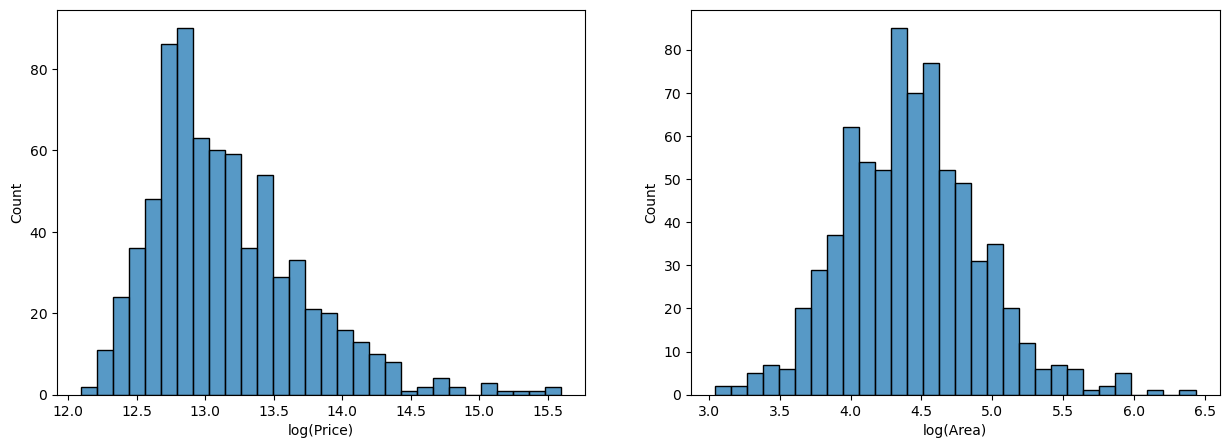

In [350]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, col in enumerate(['log(Price)', 'log(Area)']):
    plot = sns.histplot(ax=axes.flatten()[i], x = initial_data[col], bins = 30)

Logging Price did not make it normaly distributed, but it looks much better than initial Price distribution.

In [351]:
data_info.loc['log(Price)', 'distribution'] = 'right_skewed'
data_info

,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,1.0
Zip region,descrete,0.0,not normal,NaN
Zip location,descrete,0.0,not normal,NaN


In [352]:
count_outliers(data = initial_data, data_info = data_info, features = ['log(Price)'])

o 16 datapoints with log(Price) > 14.49855638486546


,Price,Area,Zip region,log(Price),log(Area)
1,2500000.0,202,0.0,14.731801,5.308268
65,3500000.0,348,0.0,15.068274,5.852202
68,3680000.0,374,0.0,15.118423,5.924256
181,2325000.0,150,0.0,14.659231,5.010635
196,4495000.0,178,0.0,15.318476,5.181784
211,4900000.0,623,0.0,15.404746,6.434547
323,2475000.0,183,0.0,14.721751,5.209486
344,2450000.0,259,0.0,14.711599,5.556828
396,2250000.0,250,0.0,14.626441,5.521461
468,5950000.0,394,0.0,15.598902,5.976351


In [353]:
correlations_df = custom_corr(initial_data, data_info, features=['log(Price)', 'log(Area)', 'Zip region'])
correlations_df

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,log(Area),log(Price),0.730393,1.208428e-123,True,736
1,Spearman,log(Area),Zip region,0.000311,9.932829e-01,False,736
2,Spearman,log(Price),Zip region,-0.356112,1.992057e-23,True,736


According to correlation matrix, the data is ready to be fed to the initial model to get benchmark accuracy:

In [354]:
X = initial_data.drop(columns=['Price', 'Area', 'log(Price)'])
y = initial_data['log(Price)']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [355]:
results = pd.DataFrame()
results['Model'] = ''
results['List of used features'] = []
results['Target'] = ''
results['RMSE'] = np.nan
results['MAE'] = np.nan
results['r_value'] = np.nan

In [356]:
def evaluate_model(name_of_model: str, model = model, X: pd.DataFrame = X, y_true: list = y, results:pd.DataFrame = results) -> pd.DataFrame():
    """Counts predictions on prepared dataset (data should be transformed to the format that model understands) and than calculates RMSE, MAE and explained variation of predicted values and adds results to the 'results'
 dataframe
    Args:
        name_of_model: str
            custom name of the model. Better use the name as in sklearn, like LogisticRegression or LinearRegression
        model. Defaults to model: 
            model, that was fit. Is needed to predict() y 
        X: pd.DataFrame. Defaults to X
            dataframe of features. Has to be 
        y_true: list. Defaults to y
            list of true y to compare them to predicted y
        results: pd.DataFrame. Defaults to results
            dataframe, where results row would be added

    Returns:
        results: pd.DataFrame. Defaults to results
            dataframe with a new row of model evaluation
    """
    
    y_pred = model.predict(X)
    
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    MAE = mean_absolute_error(y_true, y_pred)
    r_value = explained_variance_score(y_true, y_pred)

    new_row = [name_of_model, list(X.columns), y_true.name, RMSE, MAE, r_value]
    results.loc[len(results)] = new_row
    return results

evaluate_model("Linear Regression")

,Model,List of used features,Target,RMSE,MAE,r_value
0,Linear Regression,"[Zip region, log(Area)]",log(Price),0.29872,0.231755,0.706485


There is a lot of room for improvement. First, let's check if it will improve the model to add Longitude and Latitude features as 'Distance from the city center'. Most popular formulas for calculating diistance between 2 points are Euclidean and Manhattan distance. There is also Haversine formula to count distance between 2 poins on the map having their latitude and longitude. Let's count 3 of them and defice which correlates better with the Target:

**Haversine formula**:

a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)

c = 2 ⋅ atan2( √a, √(1−a) )

d = R ⋅ c

where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);

**Euclidean distance**:

d = √[(φ1 - φ2)² + (λ1 - λ2)²]

**Manhattan distance**:

d = |φ1 - φ2| + |λ1 - λ2|

In [357]:
initial_data['Lon'] = data['Lon']
initial_data['Lat'] = data['Lat']

center_lat = initial_data['Lat'].mean()
center_lon = initial_data['Lon'].mean()

In [358]:
def distance_betw_2points(point_lat: float, center_lat: float, point_lon: float, center_lon: float, method: str) -> float:

    if method in ['Haversine', 'Euclidean', 'Manhattan']:

        if method == 'Haversine':
        
            # φ, λ in radians
            center_lat = center_lat * pi/180
            center_lon = center_lon * pi/180

            R = 6371e3 # in meters

            point_lat = point_lat * pi/180
            point_lon = point_lon * pi/180
            delta_lat = np.abs(point_lat - center_lat)
            delta_lon = np.abs(point_lon - center_lon)

            a = np.square(np.sin(delta_lat/2)) + np.cos(point_lat) * np.cos(center_lat) * np.square(np.sin(delta_lon/2))
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
            d = R * c

            return d

        elif method == 'Euclidean':

            d = np.sqrt(np.square(center_lat - point_lat) + np.square(center_lon - point_lon))
            return d
        
        else:

            d = np.abs(center_lat - point_lat) + np.abs(center_lon - point_lon)
            return d  
        
    else: 
        print('Method not in [Haversine, Euclidean, Manhattan]')

In [359]:
# generate distance features
initial_data = initial_data.assign(
    **{
        "Euclidean_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Euclidean'
        ),
        "Manhattan_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Manhattan'
        ),
        "Haversine_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Haversine'
        )
    }
)

In [360]:
initial_data.head()

,Price,Area,Zip region,log(Price),log(Area),Lon,Lat,Euclidean_distance,Manhattan_distance,Haversine_distance
0,325000.0,41,0.0,12.691580,3.713572,4.867459,52.375562,0.025186,0.034299,2026.287525
1,2500000.0,202,0.0,14.731801,5.308268,4.876117,52.359763,0.013736,0.016749,981.088854
2,825000.0,148,0.0,13.623139,4.997212,4.895224,52.361929,0.005953,0.007099,419.807911
3,699000.0,98,0.0,13.457406,4.584967,4.861985,52.322384,0.049189,0.068260,4907.820881
4,1795000.0,158,0.0,14.400516,5.062595,4.912109,52.350755,0.025893,0.035158,2072.657692


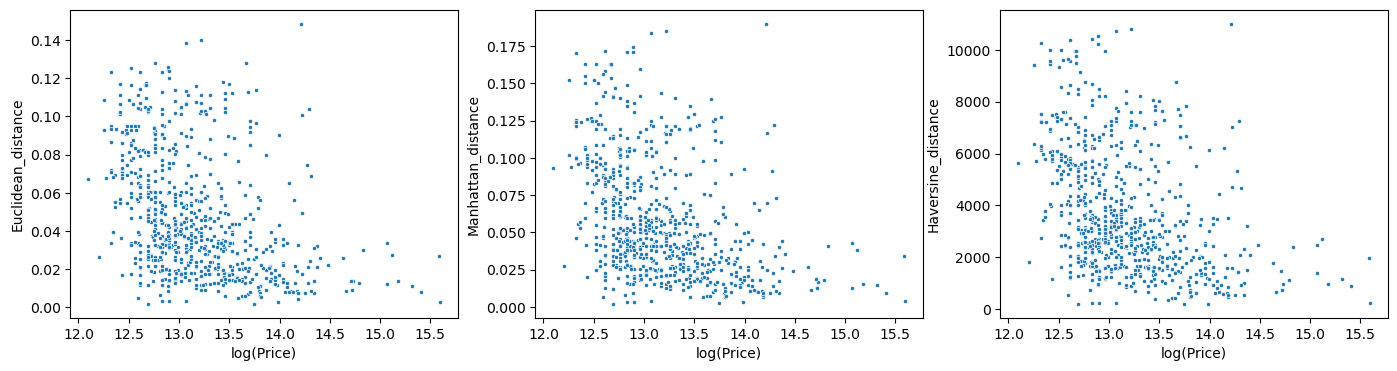

In [361]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4))
for count, feature in enumerate(initial_data.columns[-3:]):
    sns.scatterplot(data = initial_data, x = 'log(Price)', y = feature, marker='.', ax = axes.flatten()[count])

In [362]:
# in order to get correlations, we have to know the type of distribution of new features

data_info.loc['Euclidean_distance', 'data_type'] = 'continuous'
data_info.loc['Manhattan_distance', 'data_type'] = 'continuous'
data_info.loc['Haversine_distance', 'data_type'] = 'continuous'
data_info.loc['Euclidean_distance', 'missing values'] = 0
data_info.loc['Manhattan_distance', 'missing values'] = 0
data_info.loc['Haversine_distance', 'missing values'] = 0

normality_check(data = initial_data, data_info = data_info, features=initial_data.columns[-3:])

,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,1.0
Zip region,descrete,0.0,not normal,NaN
Zip location,descrete,0.0,not normal,NaN


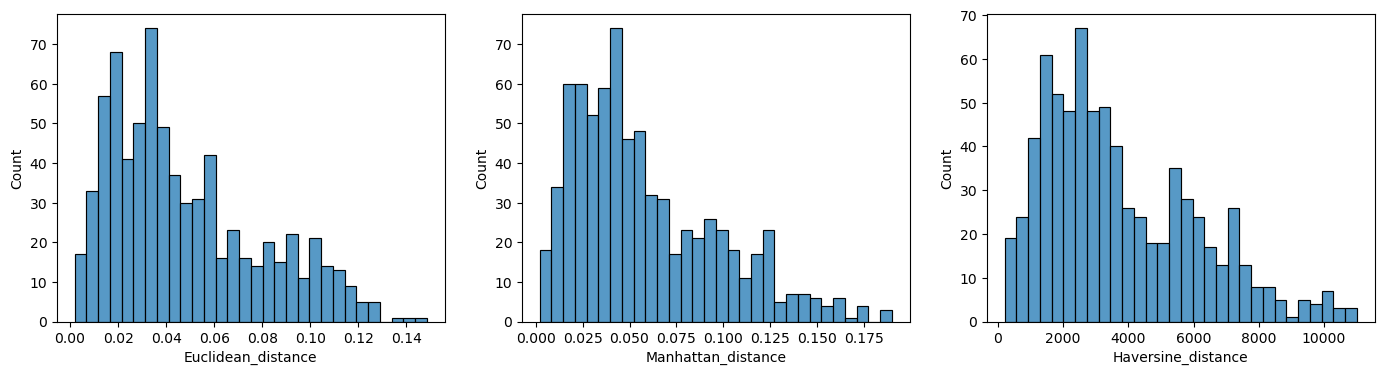

In [363]:
# because the distribution is not normal, lets plot it and manualy define the subtype, which is needed to find the outliers:

fig, axes = plt.subplots(1, 3, figsize = (17,4))
for count, feature in enumerate(data_info[-3:].index):
    sns.histplot(x = initial_data[feature], bins = 30, ax = axes.flatten()[count])

**All 3 destributions are deffinitely right-skewed**

In [364]:
for feature in data_info[-3:].index:
    data_info.loc[feature, 'distribution'] = 'right_skewed'

In [365]:
count_outliers(initial_data, data_info, ['Euclidean_distance', 'Manhattan_distance', 'Haversine_distance'])

o 3 datapoints with Euclidean_distance > 0.13613784799897793


,Price,Area,Zip region,log(Price),log(Area),Lon,Lat,Euclidean_distance,Manhattan_distance,Haversine_distance
349,475000.0,118,1.0,13.071070,4.770685,5.015376,52.305296,0.138642,0.183884,10711.301218
427,1495000.0,214,0.0,14.217637,5.365976,5.029122,52.413550,0.148500,0.190043,11009.797842
512,549001.0,107,1.0,13.215856,4.672829,5.016522,52.305075,0.139776,0.185251,10788.346694


o 8 datapoints with Manhattan_distance > 0.16564639947428073


,Price,Area,Zip region,log(Price),log(Area),Lon,Lat,Euclidean_distance,Manhattan_distance,Haversine_distance
26,375000.0,98,1.0,12.834681,4.584967,4.990488,52.292974,0.123087,0.171318,10401.174805
164,395000.0,115,1.0,12.886641,4.744932,4.995049,52.297600,0.124357,0.171253,10235.337785
349,475000.0,118,1.0,13.071070,4.770685,5.015376,52.305296,0.138642,0.183884,10711.301218
390,300000.0,84,1.0,12.611538,4.430817,4.991578,52.293948,0.123434,0.171434,10369.488586
427,1495000.0,214,0.0,14.217637,5.365976,5.029122,52.413550,0.148500,0.190043,11009.797842
512,549001.0,107,1.0,13.215856,4.672829,5.016522,52.305075,0.139776,0.185251,10788.346694
524,395000.0,101,1.0,12.886641,4.615121,4.993551,52.292948,0.125629,0.174407,10541.933098
565,225000.0,56,1.0,12.323856,4.025352,4.992412,52.295757,0.123125,0.170459,10259.446060


o 2 datapoints with Haversine_distance > 10727.22887838862


,Price,Area,Zip region,log(Price),log(Area),Lon,Lat,Euclidean_distance,Manhattan_distance,Haversine_distance
427,1495000.0,214,0.0,14.217637,5.365976,5.029122,52.413550,0.148500,0.190043,11009.797842
512,549001.0,107,1.0,13.215856,4.672829,5.016522,52.305075,0.139776,0.185251,10788.346694


Points with indexes [427, 512] are outliers by all 3 metrics because they are way too fat from the city center. Lets remove them.

In [366]:
initial_data = initial_data.drop([427, 512], axis=0)
data = data.drop([427, 512], axis=0)

# reset indexes after removing rows
initial_data = initial_data.reset_index()
initial_data = initial_data.drop(columns=['index'])

data = data.reset_index()
data = data.drop(columns=['index'])


initial_data = initial_data.drop(columns=['Price', 'Area', 'Lat', 'Lon'])

In [367]:
custom_corr(initial_data, data_info, initial_data.columns)

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,log(Area),Zip region,-0.002178,9.530264e-01,False,734
1,Spearman,log(Area),log(Price),0.728988,1.293424e-122,True,734
2,Spearman,log(Area),Euclidean_distance,0.053824,1.451719e-01,False,734
3,Spearman,log(Area),Manhattan_distance,0.049680,1.787938e-01,False,734
4,Spearman,log(Area),Haversine_distance,0.068251,6.459060e-02,False,734
5,Spearman,Zip region,log(Price),-0.360649,5.757264e-24,True,734
6,Spearman,Zip region,Euclidean_distance,0.411643,2.188107e-31,True,734
7,Spearman,Zip region,Manhattan_distance,0.450262,6.311267e-38,True,734
8,Spearman,Zip region,Haversine_distance,0.444789,6.013954e-37,True,734
9,Spearman,log(Price),Euclidean_distance,-0.452021,3.032474e-38,True,734


Here we can see, that Manhattan_distance has the strongest correlation with the target. It is also correlated with the 'Zip region', however the impact of Manhattan_distance on the target is stronger, so at this point we **remove the following features:**
 - Euclidean_distance
 - Haversine_distance
 - Zip region

In [368]:
initial_data = initial_data.drop(columns=['Euclidean_distance', 'Haversine_distance', 'Zip region'])
initial_data

,log(Price),log(Area),Manhattan_distance
0,12.691580,3.713572,0.034299
1,14.731801,5.308268,0.016749
2,13.623139,4.997212,0.007099
3,13.457406,4.584967,0.068260
4,14.400516,5.062595,0.035158
...,...,...,...
729,13.122363,4.727388,0.079571
730,12.560244,3.610918,0.099910
731,13.437174,4.672829,0.042029
732,12.524526,3.135494,0.024512


In [369]:
# In order to make both features have equal impact, the log() function is applied to Manhattan_distance:
initial_data['Manhattan_distance'] = np.log(initial_data['Manhattan_distance'])

In [370]:
X2 = initial_data.drop(columns=['log(Price)'])
y2 = initial_data['log(Price)']

model2 = LinearRegression()
model2.fit(X2, y2)

LinearRegression()

In [371]:
evaluate_model("Linear Regression2", model = model2, X = X2, y_true = y2)

,Model,List of used features,Target,RMSE,MAE,r_value
0,Linear Regression,"[Zip region, log(Area)]",log(Price),0.298720,0.231755,0.706485
1,Linear Regression2,"[log(Area), Manhattan_distance]",log(Price),0.229779,0.171835,0.825932


# Model with price per sqm

In [372]:
data.tail()

,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
729,"Joop Gerritzestraat 14, Amsterdam",1063 EK,500000.0,113,6,4.830151,52.383526,4424.778761
730,"Laan van Vlaanderen 141 A2*, Amsterdam",1066 MP,285000.0,37,2,4.807805,52.344914,7702.702703
731,"Henri Zagwijnstraat 14 3, Amsterdam",1077 XR,685000.0,107,4,4.868754,52.341846,6401.869159
732,"Marnixstraat 237 E, Amsterdam",1015 WE,275000.0,23,1,4.877725,52.376041,11956.521739
733,"Zandstraat 5 hs, Amsterdam",1011 HJ,560000.0,80,2,4.898846,52.370303,7000.000000


In [373]:
initial_data['log(Price per sqm)'] = np.log(data['Price per sqm'])
initial_data['Room'] = data['Room']
initial_data

,log(Price),log(Area),Manhattan_distance,log(Price per sqm),Room
0,12.691580,3.713572,-3.372653,8.978008,2
1,14.731801,5.308268,-4.089420,9.423534,6
2,13.623139,4.997212,-4.947733,8.625926,3
3,13.457406,4.584967,-2.684432,8.872439,3
4,14.400516,5.062595,-3.347889,9.337921,6
...,...,...,...,...,...
729,13.122363,4.727388,-2.531112,8.394976,6
730,12.560244,3.610918,-2.303486,8.949327,2
731,13.437174,4.672829,-3.169397,8.764345,4
732,12.524526,3.135494,-3.708612,9.389032,1


,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,1.0
Zip region,descrete,0.0,not normal,NaN
Zip location,descrete,0.0,not normal,NaN


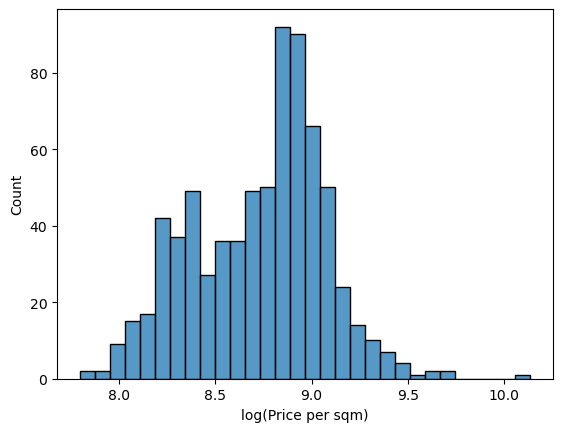

In [374]:
sns.histplot(x = initial_data['log(Price per sqm)'], bins = 30)
data_info.loc['log(Price per sqm)', 'data_type'] = 'continuous'
data_info.loc['log(Price per sqm)', 'missing values'] = 0

normality_check(initial_data, data_info, ['log(Price per sqm)'])
data_info

In [375]:
data_info.loc['log(Price per sqm)', 'distribution'] = 'left-skewed'

In [376]:
custom_corr(initial_data, data_info, features=['log(Price per sqm)', 'Manhattan_distance', 'Room'])

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,log(Price per sqm),Manhattan_distance,-0.777027,2.672318e-149,True,734
1,Spearman,log(Price per sqm),Room,-0.199057,5.380341e-08,True,734
2,Spearman,Manhattan_distance,Room,0.105577,4.190174e-03,True,734


In [377]:
X3 = initial_data.drop(columns=['log(Price per sqm)', 'log(Price)'])
y3 = initial_data['log(Price per sqm)']

model3 = LinearRegression()
model3.fit(X3, y3)

pred_log_price_sqm = model3.predict(X3)

In [378]:
X3

,log(Area),Manhattan_distance,Room
0,3.713572,-3.372653,2
1,5.308268,-4.089420,6
2,4.997212,-4.947733,3
3,4.584967,-2.684432,3
4,5.062595,-3.347889,6
...,...,...,...
729,4.727388,-2.531112,6
730,3.610918,-2.303486,2
731,4.672829,-3.169397,4
732,3.135494,-3.708612,1


In [379]:
RMSE = mean_squared_error(y3, pred_log_price_sqm, squared=False)
MAE = mean_absolute_error(y3, pred_log_price_sqm)
r_value = explained_variance_score(y3, pred_log_price_sqm)

print(RMSE, MAE, r_value)

0.22949098100684096 0.17118111737064864 0.5538976148645607


In [380]:
# back transformation from log to numbers
initial_data['pred_price_sqm'] = np.exp(pred_log_price_sqm)
initial_data['Area'] = np.exp(initial_data['log(Area)'])
initial_data['pred_Price'] = initial_data['pred_price_sqm'] * initial_data['Area']
initial_data['real_Price'] = data['Price']

RMSE = mean_squared_error(initial_data['real_Price'], initial_data['pred_Price'], squared=False)
MAE = mean_absolute_error(initial_data['real_Price'], initial_data['pred_Price'])
r_value = explained_variance_score(initial_data['real_Price'], initial_data['pred_Price'])
print(RMSE, MAE, r_value)

258732.49994832373 120309.81760381207 0.7864114245364303


In [381]:
initial_data

,log(Price),log(Area),Manhattan_distance,log(Price per sqm),Room,pred_price_sqm,Area,pred_Price,real_Price
0,12.691580,3.713572,-3.372653,8.978008,2,7303.568534,41.0,2.994463e+05,325000.0
1,14.731801,5.308268,-4.089420,9.423534,6,7922.382616,202.0,1.600321e+06,2500000.0
2,13.623139,4.997212,-4.947733,8.625926,3,10574.337605,148.0,1.565002e+06,825000.0
3,13.457406,4.584967,-2.684432,8.872439,3,5264.801450,98.0,5.159505e+05,699000.0
4,14.400516,5.062595,-3.347889,9.337921,6,6393.624140,158.0,1.010193e+06,1795000.0
...,...,...,...,...,...,...,...,...,...
729,13.122363,4.727388,-2.531112,8.394976,6,5090.562956,113.0,5.752336e+05,500000.0
730,12.560244,3.610918,-2.303486,8.949327,2,5192.354111,37.0,1.921171e+05,285000.0
731,13.437174,4.672829,-3.169397,8.764345,4,6186.070958,107.0,6.619096e+05,685000.0
732,12.524526,3.135494,-3.708612,9.389032,1,8684.884266,23.0,1.997523e+05,275000.0
